# Solar Power Forecasting Using Vector Auto Regression

1. Read labeled data from output.xlsx
2. Set forecast_days
3. Generate probabilistic labels
4. Run VAR

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
forecast_days = 12

In [21]:
xls = pd.ExcelFile("output.xlsx")

In [22]:
years = ["2012","2013","2014","2015","2016","2017","2018","2019","2020"]

In [23]:
df_obj = dict()
for i in years:
    df_obj[i] = pd.read_excel(xls, i)
    df_obj[i] = df_obj[i].drop(["Unnamed: 0"],axis=True)

## Forecasting start

In [24]:
df_obj['2015'].columns

Index(['Date', '1104500527', '1104500529', '1.104501e+09', '7802195.0',
       '2100570073/ 2100567820/ 2100567898', 'Total Generation (KWH)',
       'Aggregate Meter Reading (KWH)', 'Difference', 'SEEDs data (KWH)',
       'Insolation', 'PR (%)', 'Any Issues/Problems Observed', 'WO#',
       'NO-OFF-CLEAN MODULES', 'Grid Failure', 'Inverter', 'Module Cleaning',
       'Rainy day', 'No Module Cleaning',
       'Transformer replacement and maintenance', 'Cable and Fuse maintenance',
       'Plant Shutdown', 'Internet', 'Battery', 'Cloudy',
       'Module Cleaning by rains'],
      dtype='object')

In [25]:
df = df_obj['2012']
# df = df.append(df_obj['2016'])
for i in range(2013,2019):
    df = df.append(df_obj[str(i)])
    
df1 = df.drop(["1104500527", "1104500529", "1.104501e+09", "7802195.0", "2100570073/ 2100567820/ 2100567898", 
                    "Aggregate Meter Reading (KWH)", 
                    "Difference", "SEEDs data (KWH)", "Insolation", 
                    "PR (%)", "Any Issues/Problems Observed", "WO#", "NO-OFF-CLEAN MODULES"], axis=1)

In [26]:
df1

Date  Total Generation (KWH)  Grid Failure  Inverter  \
0   2012-07-06                 3218.00             1         0   
1   2012-07-07                 3633.00             1         0   
2   2012-07-08                 4377.00             0         1   
3   2012-07-09                 4625.00             0         1   
4   2012-07-10                  648.00             0         1   
..         ...                     ...           ...       ...   
360 2018-12-27                 4129.29             1         0   
361 2018-12-28                 4266.50             0         0   
362 2018-12-29                 3732.03             1         0   
363 2018-12-30                 4063.88             0         1   
364 2018-12-31                 4093.90             1         0   

     Module Cleaning  Rainy day  No Module Cleaning  \
0                  0          0                   0   
1                  0          0                   0   
2                  0          0                   0   
3                  0          0                   0   
4                  0          0                   0   
..               ...        ...                 ...   
360                1          0                   0   
361                1          0                   0   
362                1          0                   0   
363                0          0                   0   
364                1          0                   0   

     Transformer replacement and maintenance  Cable and Fuse maintenance  \
0                                          0                           0   
1                                          0                           0   
2                                          0                           0   
3                                          0                           0   
4                                          0                           0   
..                                       ...                         ...   
360                                        0                           0   
361                                        0                           0   
362                                        0                           0   
363                                        0                           0   
364                                        0                           0   

     Plant Shutdown  Internet  Battery  Cloudy  Module Cleaning by rains  
0                 0         0        0       0                         0  
1                 0         0        0       0                         0  
2                 0         0        0       0                         0  
3                 0         0        0       0                         0  
4                 0         0        0       0                         0  
..              ...       ...      ...     ...                       ...  
360               0         0        0       0                         0  
361               0         0        0       0                         0  
362               0         0        0       0                         0  
363               0         0        0       0                         0  
364               0         0        0       0                         0  

[2370 rows x 14 columns]

In [27]:
df1['Date'] = pd.to_datetime(df1['Date'])

In [28]:
df1 = df1.set_index('Date')

In [29]:
# for i in df1.columns[1:]:
#     print(i)
#     temp = df1[i].value_counts().to_dict()
#     print(temp)
#     if 1.0 in temp.keys():
#         df1[str(i)][df1[str(i)] == 1.0] = (temp[1.0]/100)**12

In [30]:
df1.head()

Total Generation (KWH)  Grid Failure  Inverter  Module Cleaning  \
Date                                                                          
2012-07-06                  3218.0             1         0                0   
2012-07-07                  3633.0             1         0                0   
2012-07-08                  4377.0             0         1                0   
2012-07-09                  4625.0             0         1                0   
2012-07-10                   648.0             0         1                0   

            Rainy day  No Module Cleaning  \
Date                                        
2012-07-06          0                   0   
2012-07-07          0                   0   
2012-07-08          0                   0   
2012-07-09          0                   0   
2012-07-10          0                   0   

            Transformer replacement and maintenance  \
Date                                                  
2012-07-06                                        0   
2012-07-07                                        0   
2012-07-08                                        0   
2012-07-09                                        0   
2012-07-10                                        0   

            Cable and Fuse maintenance  Plant Shutdown  Internet  Battery  \
Date                                                                        
2012-07-06                           0               0         0        0   
2012-07-07                           0               0         0        0   
2012-07-08                           0               0         0        0   
2012-07-09                           0               0         0        0   
2012-07-10                           0               0         0        0   

            Cloudy  Module Cleaning by rains  
Date                                          
2012-07-06       0                         0  
2012-07-07       0                         0  
2012-07-08       0                         0  
2012-07-09       0                         0  
2012-07-10       0                         0

In [31]:
df1['Total Generation (KWH)'] = pd.to_numeric(df1['Total Generation (KWH)'])
df1['Total Generation (KWH)'].dtype

dtype('float64')

In [32]:
corr_df = df1.corr()
# corr_df[corr_df < 0] = 0
corr_df

Total Generation (KWH)  Grid Failure  \
Total Generation (KWH)                                 1.000000     -0.130600   
Grid Failure                                          -0.130600      1.000000   
Inverter                                              -0.314601      0.057966   
Module Cleaning                                        0.128121      0.028741   
Rainy day                                             -0.243720      0.006965   
No Module Cleaning                                    -0.005216     -0.071054   
Transformer replacement and maintenance               -0.050500     -0.008649   
Cable and Fuse maintenance                             0.032419     -0.004769   
Plant Shutdown                                         0.014604      0.027274   
Internet                                               0.058770      0.007146   
Battery                                               -0.042502     -0.006409   
Cloudy                                                -0.430203     -0.026162   
Module Cleaning by rains                                    NaN           NaN   

                                         Inverter  Module Cleaning  Rainy day  \
Total Generation (KWH)                  -0.314601         0.128121  -0.243720   
Grid Failure                             0.057966         0.028741   0.006965   
Inverter                                 1.000000        -0.240594   0.345086   
Module Cleaning                         -0.240594         1.000000  -0.097901   
Rainy day                                0.345086        -0.097901   1.000000   
No Module Cleaning                      -0.065587        -0.138123  -0.026688   
Transformer replacement and maintenance  0.047602         0.046175   0.022688   
Cable and Fuse maintenance              -0.057207         0.036938  -0.004281   
Plant Shutdown                          -0.006944         0.028864  -0.002826   
Internet                                -0.045619        -0.103348  -0.022166   
Battery                                  0.107890        -0.076412  -0.014764   
Cloudy                                   0.170230        -0.206888   0.304770   
Module Cleaning by rains                      NaN              NaN        NaN   

                                         No Module Cleaning  \
Total Generation (KWH)                            -0.005216   
Grid Failure                                      -0.071054   
Inverter                                          -0.065587   
Module Cleaning                                   -0.138123   
Rainy day                                         -0.026688   
No Module Cleaning                                 1.000000   
Transformer replacement and maintenance           -0.017444   
Cable and Fuse maintenance                         0.008297   
Plant Shutdown                                    -0.003987   
Internet                                          -0.031273   
Battery                                           -0.020830   
Cloudy                                             0.032792   
Module Cleaning by rains                                NaN   

                                         Transformer replacement and maintenance  \
Total Generation (KWH)                                                 -0.050500   
Grid Failure                                                           -0.008649   
Inverter                                                                0.047602   
Module Cleaning                                                         0.046175   
Rainy day                                                               0.022688   
No Module Cleaning                                                     -0.017444   
Transformer replacement and maintenance                                 1.000000   
Cable and Fuse maintenance                                             -0.015215   
Plant Shutdown                                                         -0.001847   
Internet                                        

In [33]:
# total_0 = 0
# total_1 = 0
# for i in df1.columns[1:]:
#     value_c = df1[i].value_counts()
#     print(df1[i].value_counts())
#     total_0 += value_c[]

In [34]:
df1 = df1.drop(["Cable and Fuse maintenance","No Module Cleaning","Rainy day","Transformer replacement and maintenance","Plant Shutdown","Internet","Battery","Module Cleaning by rains"], axis=1)
df1

Total Generation (KWH)  Grid Failure  Inverter  Module Cleaning  \
Date                                                                          
2012-07-06                 3218.00             1         0                0   
2012-07-07                 3633.00             1         0                0   
2012-07-08                 4377.00             0         1                0   
2012-07-09                 4625.00             0         1                0   
2012-07-10                  648.00             0         1                0   
...                            ...           ...       ...              ...   
2018-12-27                 4129.29             1         0                1   
2018-12-28                 4266.50             0         0                1   
2018-12-29                 3732.03             1         0                1   
2018-12-30                 4063.88             0         1                0   
2018-12-31                 4093.90             1         0                1   

            Cloudy  
Date                
2012-07-06       0  
2012-07-07       0  
2012-07-08       0  
2012-07-09       0  
2012-07-10       0  
...            ...  
2018-12-27       0  
2018-12-28       0  
2018-12-29       0  
2018-12-30       0  
2018-12-31       0  

[2370 rows x 5 columns]

In [35]:
endog_array = df1.to_numpy(dtype=int)

In [36]:
var_model = VAR(endog_array)

In [37]:
var_model.select_order(48).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [38]:
results = var_model.fit(15, trend='c', ic='aic')

In [39]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Mar, 2022
Time:                     16:42:31
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    3.51735
Nobs:                     2355.00    HQIC:                   2.92594
Log likelihood:          -19374.5    FPE:                    13.2944
AIC:                      2.58723    Det(Omega_mle):         11.3422
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const        429.308862       103.472155            4.149           0.000
L1.y1          0.565818         0.021648           26.137           0.000
L1.y2         96.226095        31.150276            3.089           0.002
L1.y3        -94.

Text(0, 0.5, 'std. error')

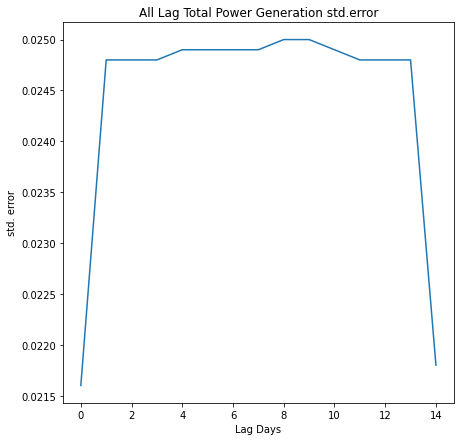

In [40]:
stderr_value = list(results.stderr)[1:]
error_value = []
for i in range(75):
    if i % 5 == 0:
        error_value.append(round(stderr_value[i][0],4))
fig = plt.figure(figsize=(7,7))
plt.plot(error_value)    
plt.title("All Lag Total Power Generation std.error")
plt.xlabel('Lag Days')
plt.ylabel('std. error')

In [41]:
# fig.savefig('std_error')

In [42]:
for i in list(results.stderr)[1]:
    print(round(i,3))

0.022
0.0
0.0
0.0
0.0


In [43]:
for index, i in enumerate(list(results.stderr)):
    print(index, i[1])

0 0.07061483084073714
1 1.4773800068555275e-05
2 0.021258583483893485
3 0.04631027235515819
4 0.037052751524707564
5 0.0554737508767605
6 1.6905371195592538e-05
7 0.021388492732983336
8 0.048430852102329454
9 0.03791706395132411
10 0.06179673376285543
11 1.694991062226761e-05
12 0.021415586227213138
13 0.048886961885202765
14 0.03811550357654039
15 0.06212911946071615
16 1.6954123546114197e-05
17 0.021358597406731784
18 0.04888428108253552
19 0.03838269716350452
20 0.062383773120787696
21 1.696469174653834e-05
22 0.0213518400274767
23 0.04880376684567531
24 0.03839825914895927
25 0.06252839760042381
26 1.702062988127131e-05
27 0.021320417695760877
28 0.04866553957001879
29 0.03835621827619446
30 0.06247129584261933
31 1.7021913997116675e-05
32 0.021286779317919998
33 0.0486054773291957
34 0.03830837976649931
35 0.06254542367330813
36 1.7016155547276998e-05
37 0.02128697571128663
38 0.04902606925737894
39 0.04022509296472131
40 0.06259100515452838
41 1.702822943937816e-05
42 0.021278759

In [44]:
lag = results.k_ar

In [45]:
forecast_results = results.forecast(df1.values[-lag:],steps=forecast_days)

## Results

In [46]:
forecast_power = []
grid_pred = []
inverter_pred = []
module_pred = []
cloudy_pred = []
for i in forecast_results:
    forecast_power.append(i[0])
    grid_pred.append(i[1])
    inverter_pred.append(i[2])
    module_pred.append(i[3])
    cloudy_pred.append(i[4])

In [47]:
power_16 = df_obj['2019']['Total Generation (KWH)']
diff_power = pd.DataFrame({"Prediction":forecast_power[:forecast_days],"Original":power_16[:forecast_days],
                           "Grid_pred":grid_pred[:forecast_days],
                          "Module_pred":module_pred[:forecast_days],"Cloudy_pred":cloudy_pred[:forecast_days],
                          "Inverter_pred":inverter_pred[:forecast_days]})
diff_power['Difference'] = diff_power['Prediction'] - diff_power['Original']
diff_power

Prediction  Original  Grid_pred  Module_pred  Cloudy_pred  Inverter_pred  \
0   4006.415791   3812.94   0.487502     0.919024     0.013340       0.134071   
1   4018.499292   3920.74   0.421920     0.938666    -0.020539       0.074634   
2   4176.960999   4113.45   0.411235     0.924108    -0.006022       0.113328   
3   4119.503935   3873.59   0.372910     0.883409    -0.001627       0.104822   
4   3921.924689   3603.61   0.558229     0.943164     0.006326       0.079327   
5   3916.175485   4401.37   0.394121     0.269509     0.027434       0.299704   
6   3903.286758   3852.56   0.548953     0.986328     0.034072       0.063813   
7   3875.556369   3913.55   0.456653     0.823999     0.074195       0.145397   
8   4044.455014   3731.08   0.339145     0.835986     0.033584       0.128262   
9   3992.133402   4058.75   0.376363     0.850405     0.043758       0.084118   
10  3936.363030   4077.43   0.489564     0.749100     0.062393       0.154264   
11  3940.240990   3923.99   0.536016     0.866396     0.051428       0.064682   

    Difference  
0   193.475791  
1    97.759292  
2    63.510999  
3   245.913935  
4   318.314689  
5  -485.194515  
6    50.726758  
7   -37.993631  
8   313.375014  
9   -66.616598  
10 -141.066970  
11   16.250990

## Plot results

In [48]:
date_list = pd.date_range(start="2019-01-01",end="2019-01-30")
date_list = pd.to_datetime(date_list)
diff_power['Date'] = date_list[:forecast_days]

In [49]:
diff_power

Prediction  Original  Grid_pred  Module_pred  Cloudy_pred  Inverter_pred  \
0   4006.415791   3812.94   0.487502     0.919024     0.013340       0.134071   
1   4018.499292   3920.74   0.421920     0.938666    -0.020539       0.074634   
2   4176.960999   4113.45   0.411235     0.924108    -0.006022       0.113328   
3   4119.503935   3873.59   0.372910     0.883409    -0.001627       0.104822   
4   3921.924689   3603.61   0.558229     0.943164     0.006326       0.079327   
5   3916.175485   4401.37   0.394121     0.269509     0.027434       0.299704   
6   3903.286758   3852.56   0.548953     0.986328     0.034072       0.063813   
7   3875.556369   3913.55   0.456653     0.823999     0.074195       0.145397   
8   4044.455014   3731.08   0.339145     0.835986     0.033584       0.128262   
9   3992.133402   4058.75   0.376363     0.850405     0.043758       0.084118   
10  3936.363030   4077.43   0.489564     0.749100     0.062393       0.154264   
11  3940.240990   3923.99   0.536016     0.866396     0.051428       0.064682   

    Difference       Date  
0   193.475791 2019-01-01  
1    97.759292 2019-01-02  
2    63.510999 2019-01-03  
3   245.913935 2019-01-04  
4   318.314689 2019-01-05  
5  -485.194515 2019-01-06  
6    50.726758 2019-01-07  
7   -37.993631 2019-01-08  
8   313.375014 2019-01-09  
9   -66.616598 2019-01-10  
10 -141.066970 2019-01-11  
11   16.250990 2019-01-12

In [50]:
rmse = mean_squared_error(power_16[:forecast_days],forecast_power)**(1/2)
rmse

218.90968543650058

In [51]:
mae = mean_absolute_error(power_16[:forecast_days],forecast_power)
mae

169.18326509806056

In [52]:
rmspe = round(np.sqrt(np.mean(np.square(((power_16[:forecast_days] - forecast_power) / power_16[:forecast_days])), axis=0))*100,3)
rmspe

5.494

Text(0.5, 1.0, '12_Days Prediction_for_Binary_Var')

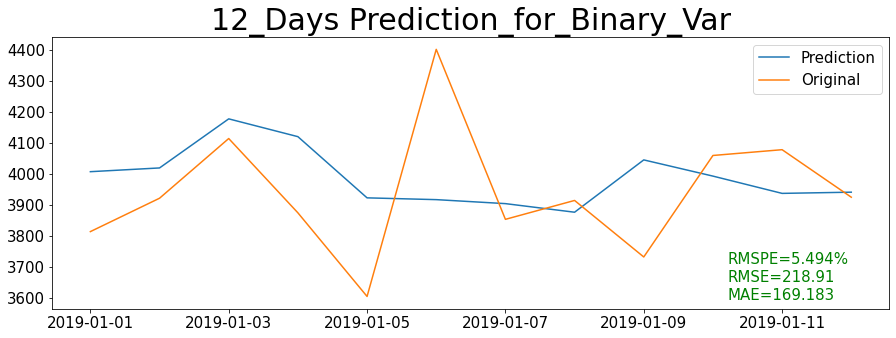

In [74]:
fig = plt.figure(figsize=(15,5))
font = {'size': 15}
plt.rc('font', **font)
plt.plot('Date', 'Prediction', data=diff_power, label='Prediction')
plt.plot('Date', 'Original', data=diff_power, label='Original')
plt.legend()
plt.figtext(.75, .25, "RMSPE="+str(round(rmspe, 3))+"%", c='g')
plt.figtext(.75, .2, "RMSE="+str(round(rmse, 3)), c='g')
plt.figtext(.75, .15, "MAE="+str(round(mae, 3)), c='g')
plt.title(str(forecast_days)+'_Days Prediction_for_Binary_Var', fontsize=30)

TypeError: Length of y (12) must match number of rows in z (2)

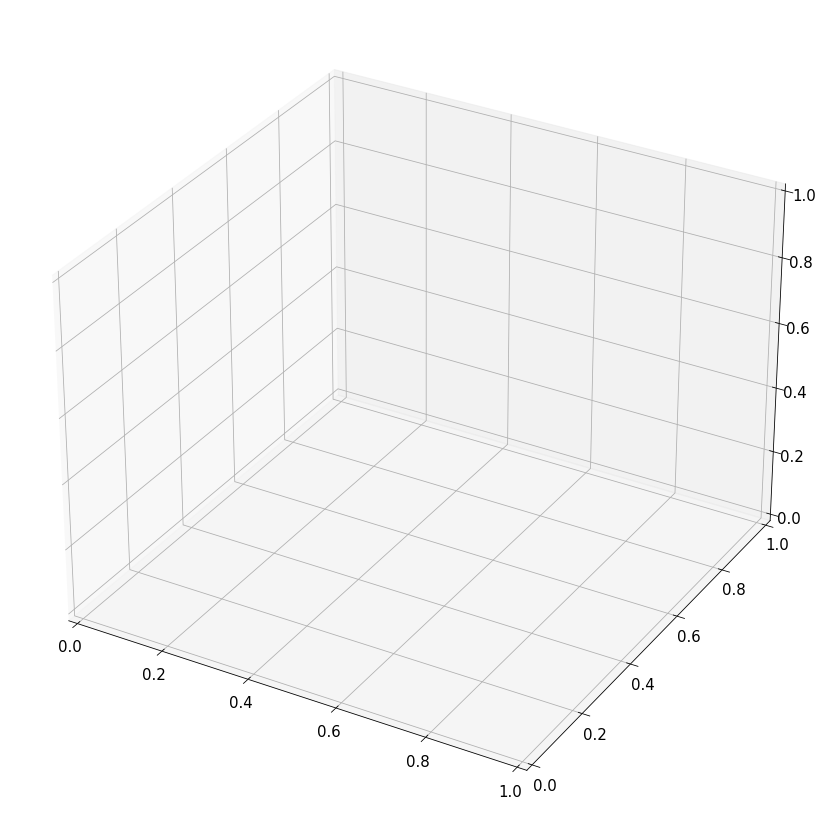

In [88]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.contour3D(diff_power['Prediction'], diff_power['Grid_pred'], [diff_power['Prediction'], diff_power['Grid_pred']], 50, cmap='binary')
ax.set_xlabel('Prediction')
ax.set_ylabel('Grid Failure')
ax.set_zlabel('Module Cleaning')

In [54]:
# fig.savefig(str(forecast_days)+'_Days Prediction_for_Binary_more_Variable')

## Fetching results

In [55]:
# writer = pd.ExcelWriter('12_days.xlsx',engine='xlsxwriter')

In [56]:
# diff_power.to_excel(writer, sheet_name='12_days')

In [57]:
# writer.save()
# writer.close()

## Check the result with regressor

In [63]:
from sklearn.ensemble import RandomForestRegressor

In [64]:
df1.head()

Total Generation (KWH)  Grid Failure  Inverter  Module Cleaning  \
Date                                                                          
2012-07-06                  3218.0             1         0                0   
2012-07-07                  3633.0             1         0                0   
2012-07-08                  4377.0             0         1                0   
2012-07-09                  4625.0             0         1                0   
2012-07-10                   648.0             0         1                0   

            Cloudy  
Date                
2012-07-06       0  
2012-07-07       0  
2012-07-08       0  
2012-07-09       0  
2012-07-10       0

In [65]:
X_train = df1.drop(["Total Generation (KWH)"], axis=1)
Y_train = df1['Total Generation (KWH)']
X_test = diff_power.drop(["Prediction","Original","Difference","Date"], axis=1)

In [66]:
X_test

Grid_pred  Module_pred  Cloudy_pred  Inverter_pred
0    0.487502     0.919024     0.013340       0.134071
1    0.421920     0.938666    -0.020539       0.074634
2    0.411235     0.924108    -0.006022       0.113328
3    0.372910     0.883409    -0.001627       0.104822
4    0.558229     0.943164     0.006326       0.079327
5    0.394121     0.269509     0.027434       0.299704
6    0.548953     0.986328     0.034072       0.063813
7    0.456653     0.823999     0.074195       0.145397
8    0.339145     0.835986     0.033584       0.128262
9    0.376363     0.850405     0.043758       0.084118
10   0.489564     0.749100     0.062393       0.154264
11   0.536016     0.866396     0.051428       0.064682

In [67]:
Y_test = diff_power['Original']

In [68]:
regr = RandomForestRegressor(max_depth=100, random_state=0)
regr.fit(X_train,Y_train)
Y_predrand = regr.predict(X_test)
print(mean_squared_error(Y_test, Y_predrand)**(1/2))
# print(r2_score(Y_test, Y_predrand))

564.3600794194939


In [69]:
count = list(range(12))

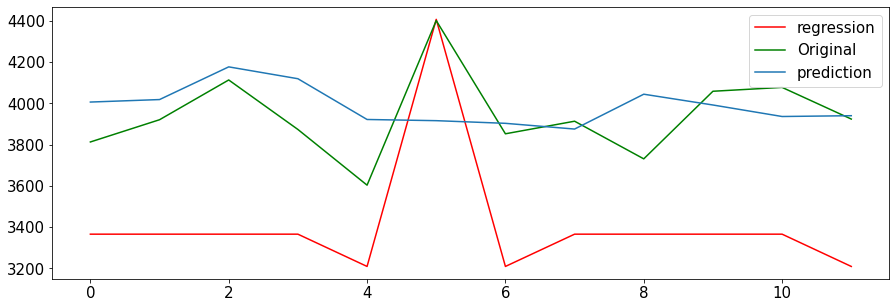

In [73]:
fig = plt.figure(figsize=(15,5))

plt.plot(count, Y_predrand, c="r", label="regression")
plt.plot(count, Y_test, c="g", label='Original')
plt.plot(count, diff_power['Prediction'], label='prediction')
plt.legend()

## Arima

In [290]:
import statsmodels as sm

In [291]:
mod = sm.tsa.arima.ARIMA(endog, order = (1, 0, 0))

AttributeError: module 'statsmodels.tsa.arima' has no attribute 'ARIMA'